#### Although single-cell RNA sequencing can reveal RNA abundance with high dimenisonal readout with high quantitative accuracy, this approach captures a snapshot of cell evolution in the sense of time. This snippet is therefore aimed to the aging velocity in the timescale of months. 

In [ ]:
import scanpy as sc # if missing, try '!pip install scanpy'
import anndata as ad
import pooch
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

import os

In [2]:
sc.settings.set_figure_params(dpi=50, facecolor="white")

### Load Dataset

As an example, use single-cell RNA-sequencing to profile hundreds of CD4+ T cells from young and old mice from two divergent species.

In [3]:
adata = sc.datasets.ebi_expression_atlas("E-MTAB-4888")

In [4]:
# view all features collectively
adata.obs.columns

Index(['Sample Characteristic[organism]',
       'Sample Characteristic Ontology Term[organism]',
       'Sample Characteristic[individual]',
       'Sample Characteristic Ontology Term[individual]',
       'Sample Characteristic[strain]',
       'Sample Characteristic Ontology Term[strain]',
       'Sample Characteristic[age]',
       'Sample Characteristic Ontology Term[age]',
       'Sample Characteristic[sex]',
       'Sample Characteristic Ontology Term[sex]',
       'Sample Characteristic[organism part]',
       'Sample Characteristic Ontology Term[organism part]',
       'Sample Characteristic[cell type]',
       'Sample Characteristic Ontology Term[cell type]',
       'Sample Characteristic[stimulus]',
       'Sample Characteristic Ontology Term[stimulus]',
       'Factor Value[single cell identifier]',
       'Factor Value Ontology Term[single cell identifier]',
       'Factor Value[strain]', 'Factor Value Ontology Term[strain]',
       'Factor Value[age]', 'Factor Value Ontol

### Quality Control

#### Filtering low quality cells

When a cell (barcode) has a small number of detected genes, a low count depth (the total number of RNA molecules detected) and a high fraction of mitochondrial counts it might have a broken membrane which can indicate a dying cell. As these cells are usually not the main target of our analysis due to their instability in gene expression data, and they might distort our downstream analysis, we remove them during quality control. To identify them, we define cell quality control (QC) threshold, on the following three QC covariates:

- The number of counts per barcode (count depth)
- The number of genes per barcode (the number of unique genes that have at least one read)
- The fraction of counts from mitochondrial genes per barcode (Healthy cells typically have a lower proportion of mitochondrial gene expression.)

In [5]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') # mitochondrial 
adata.var['ribo'] = adata.var_names.str.startswith('RPS|RPL') # ribosomal
adata.var['hb'] = adata.var_names.str.startswith("^HB[^(P)]") # hemoglobin

In [6]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

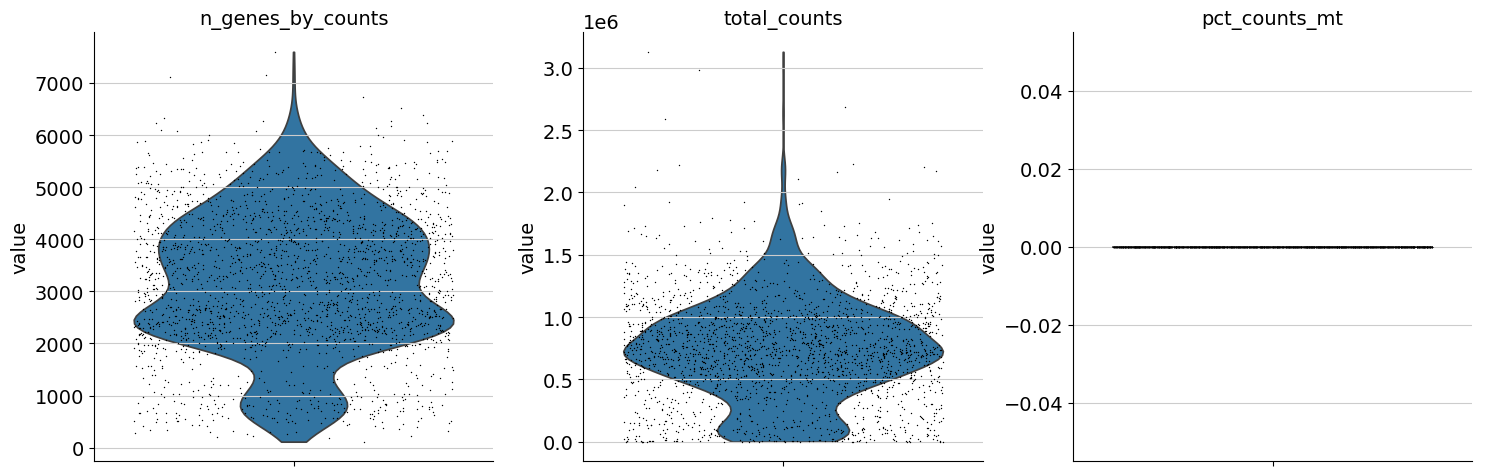

In [7]:
# The violin plot for the three characteristics above

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

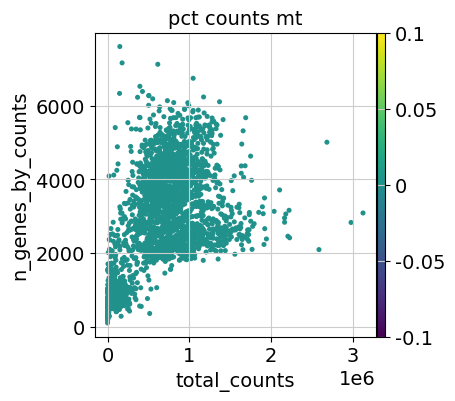

In [8]:
# scatter plot showing the RNA reads per barcode
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [9]:
# apply the filter based on the count depth and total number of unique genes

sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

#### Doublet Detection

Doublets refer to the situation where two cells that are sequenced under the same barcode, for example, if they were captured in the same droplet using conventional microfluidic approach. That explains why we used the term “barcode” instead of “cell” until now. A doublet is called homotypic if it is formed by the same cell type (but from different individuals) and heterotypic otherwise. Homotypic doublets are not necessarily identifiable from count matrices and are often considered innocuous as they can be identified with cell hashing or SNPs. Hence, their identification is not the main goal of the doublet detection methods.

Doublets formed from different cell types or states are called heterotypic. Their identification is crucial as they are most likely misclassified and can lead to distorted downstream analysis steps. Hence, doublet detection and removal are typically initial preprocessing steps. Doublets can be either identified through their high number of reads and detected features, or with methods that create artificial doublets and compare these with the cells present in the dataset. Doublet detection methods are computationally efficient and there exist other software packages for this task.

In [10]:
# scrublet is one of the methods here, based on UMAP, applying kNN  
# It does not require an external reference dataset, and computes doublet scores and provides a threshold for classification. 
# Other approachs include but not limited to: DoubletFinder, scDblFinder, etc

sc.pp.scrublet(adata)

### Normalization

The preprocessing step of “normalization” aims to adjust the raw counts in the dataset by scaling the observable variance to a specified range (amplifying the whole genome sometimes if necessary). Several normalization techniques can be used in practice based on different scenarios. In principle, they help with subsequent analysis tasks and make sure the underlying statistical methods are applicable.

A common approach is count depth scaling with subsequent log plus one (log1p) transformation. Count depth scaling normalizes the data to a “size factor” such as the median count depth in the dataset, ten thousand (CP10k) or one million (CPM, counts per million). The size factor for count depth scaling can be controlled via target_sum in pp.normalize_total. We are applying median count depth normalization with log1p transformation (AKA log1PF).

In [11]:
adata.layers["counts"] = adata.X.copy()

In [12]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

### Feature Selection

We now have a normalized data representation that still preserves biological heterogeneity but with reduced technical sampling effects in gene expression. Single-cell RNA-seq datasets usually contain up to 30,000 genes and so far we only removed genes that are not detected in at least 3 cells. However, many of the remaining genes are not informative and contain mostly zero counts. Therefore, a standard preprocessing pipeline involves the step of feature selection which aims to exclude uninformative genes which might not represent meaningful biological variation across samples.

In [13]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

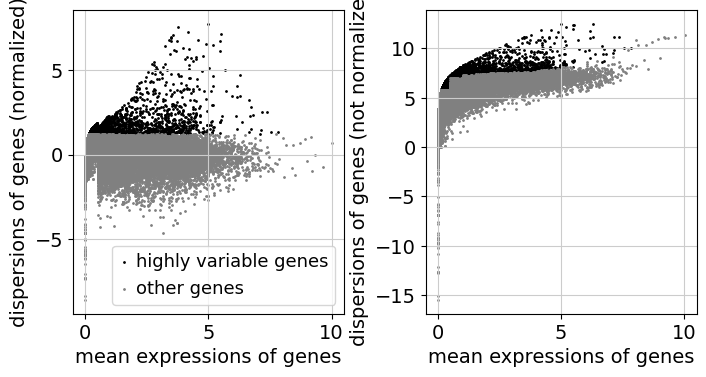

In [14]:
# display genes with high biological meanings, standing out with high dispersion before and after normalization

sc.pl.highly_variable_genes(adata)

### Dimensionality Reduction

As previously mentioned, scRNA-seq is a high-throughput sequencing technology that produces datasets with high dimensions in the number of cells and genes. This immediately begs to the question that scRNA-seq data suffers from the ‘curse of dimensionality’.

Not all genes are informative and are important for the task of cell type clustering based on their expression profiles. We already aimed to reduce the dimensionality of the data with feature selection, as a next step one can further reduce the dimensions of single-cell RNA-seq data with dimensionality reduction algorithms. These algorithms are an important step during preprocessing to reduce the data complexity and for visualization. Several dimensionality reduction techniques have been developed and used for single-cell data analysis.


#### PCA

We know that not all features are important to understand the underlying dynamics of the dataset and that there is an inherent redundancy[Grün et al., 2014]. PCA creates a new set of uncorrelated variables, so called principle components (PCs), via an orthogonal transformation of the original dataset. The PCs are linear combinations of features in the original dataset and are ranked with decreasing order of variance to define the transformation. Through the ranking usually the first PC amounts to the largest possible variance. PCs with the lowest variance are discarded to effectively reduce the dimensionality of the data without losing information.

PCA offers the advantage that it is highly interpretable and computationally efficient. However, as scRNA-seq datasets are rather sparse due to dropout events and therefore highly non-linear, visualization with the linear dimensionality reduction technique PCA is not very appropriate. PCA is typically used to select the top 10-50 PCs which are used for downstream analysis tasks, and it is important to carry PCs forward for dimensionality reduction procedures.

In [15]:
sc.tl.pca(adata)

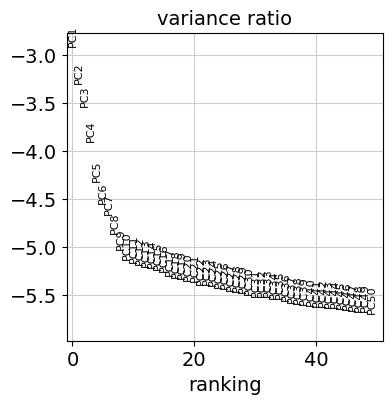

In [16]:
# show the variance explained by individual PCs on the log scale

sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

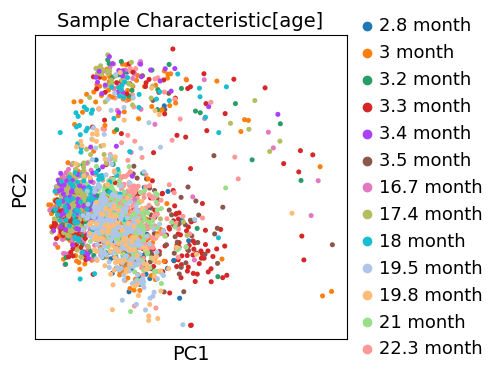

In [17]:
sc.pl.pca(
    adata, color="Sample Characteristic[age]"
)

#### t-SNE

t-SNE is a graph based, non-linear dimensionality reduction technique which projects the high dimensional data onto 2D or 3D components. The method defines a Gaussian probability distribution based on the high-dimensional Euclidean distances between data points. Subsequently, a Student t-distribution is used to recreate the probability distribution in a low dimensional space where the embeddings are optimized using gradient descent.

In [18]:
sc.tl.tsne(adata, use_rep="X_pca")

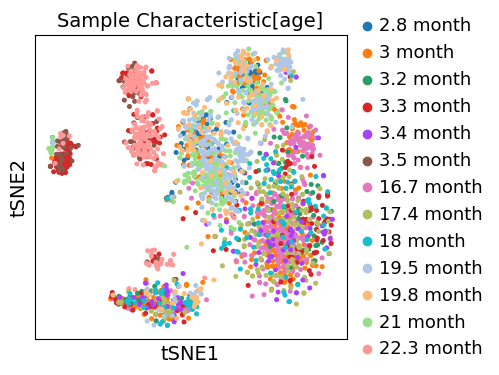

In [19]:
sc.pl.tsne(adata, color="Sample Characteristic[age]")

#### UMAP

UMAP is a graph based, non-linear dimensionality reduction technique and principally similar to t-SNE. It constructs a high dimensional graph representation of the dataset and optimizes the low-dimensional graph representation to be structurally as similar as possible to the original graph.

We first calculate PCA a neighborhood graph on our data.

In [ ]:
sc.pp.neighbors(adata)

In [21]:
sc.tl.umap(adata)

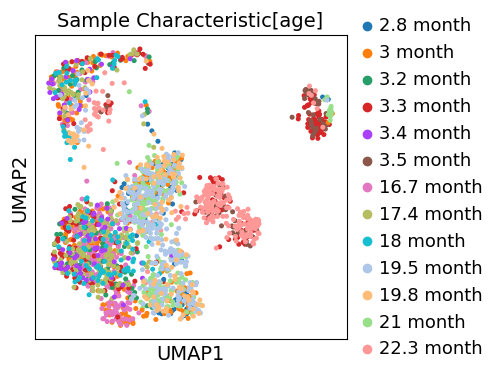

In [22]:
sc.pl.umap(
    adata,
    color="Sample Characteristic[age]",
    # Setting a smaller point size to get prevent overlap
)

### Discussion
The above results show that UMAP produces equally meaningful representations compared with t-SNE, particularly in its ability to resolve subtly differing cell populations. It also provides the useful and intuitively pleasing feature that it preserves more of the global structure and, notably, the continuity of the cell subsets. UMAP outputs are faster to compute compared with t-SNE. UMAP embeddings are more reproducible than other methods, notably more so than those from t-SNE implementations. We systematically and quantitatively benchmarked all these qualitative aspects. UMAP was found to be the best or close to best method in every aspect investigated, and thus appears as a robust all-around method for dimensionality reduction for single-cell methods. Although this will also be possible with UMAP, the autoencoder scvis currently offers the advantage of being able to append new data points to an existing embedding. The scRNAseq analysis toolkits scanpy20 and Seurat21 recently implemented UMAP as a possible tool for dimensionality reduction, and the popular commercial software platform for flow cytometry analysis FlowJo recently released a plug-in to run UMAP. Altogether, on the basis of its ease of use and results of our benchmarking analyses, we anticipate that UMAP will be a valuable tool that can be rapidly adopted by the single-cell analysis community.